# Lab-7

Answer questions in the designated cells

Resources: 
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb


If need to instal `shap` package run following commands:
```
pip uninstall numpy
pip uninstall numba
pip install shap==0.40.0
```

## Preparation

Use dataset provided in the eLearning

In [1]:
#Extend cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

In [2]:
try:
    h2o.cluster().shutdown()
except:
    pass 

In [3]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=4, max_mem_size=12)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "9"; OpenJDK Runtime Environment (build 9+181); OpenJDK 64-Bit Server VM (build 9+181, mixed mode)
  Starting server from /Users/usmashnov/var/virtual-env/ml-spring-2023/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/_z/jf3ghwdx1kg905xm5p1nktlh0000gp/T/tmpviv8rg2b
  JVM stdout: /var/folders/_z/jf3ghwdx1kg905xm5p1nktlh0000gp/T/tmpviv8rg2b/h2o_usmashnov_started_from_python.out
  JVM stderr: /var/folders/_z/jf3ghwdx1kg905xm5p1nktlh0000gp/T/tmpviv8rg2b/h2o_usmashnov_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,3 months and 3 days
H2O_cluster_name:,H2O_from_python_usmashnov_zkcnpm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


## Load Data

In [4]:
train = h2o.import_file('./data/SBA_loans_train.csv')
test = h2o.import_file('./data/SBA_loans_test.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
# Choose which columns to encode
cat_columns = ["City","State","Bank","BankState", "UrbanRural", "FranchiseCode",
               "NewExist", "RevLineCr","LowDoc", "Zip"]
response = "Defaulted"

train[cat_columns+[response]] = train[cat_columns+[response]].asfactor()
test[cat_columns+[response]] = test[cat_columns+[response]].asfactor()

## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='AUCPR',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

### Solution

In [6]:
from h2o.estimators import H2OGradientBoostingEstimator
predictors_gbm = train.columns
predictors_gbm.remove(response)
#predictors_gbm.remove('Term')

gbm_model = H2OGradientBoostingEstimator(nfolds=5,
                                         ntrees=500,
                                         stopping_rounds=5,
                                         stopping_metric='AUCPR',
                                         seed=1234,
                                         keep_cross_validation_predictions = False)

gbm_model.train(x=predictors_gbm, y=response, training_frame=train)

# retrieve the model performance
perf = gbm_model.model_performance(test)
print(perf)


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.041216624509893815
RMSE: 0.20301877871244772
LogLoss: 0.144991348917665
Mean Per-Class Error: 0.09132419940585598
AUC: 0.9757653531934147
AUCPR: 0.9055958111480693
Gini: 0.9515307063868295

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3836634361652664
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      89498  3191   0.0344   (3191.0/92689.0)
1      2921   16786  0.1482   (2921.0/19707.0)
Total  92419  19977  0.0544   (6112.0/112396.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383663     0.845983  203
max f2                       0.172625     0.87745   271
max f0point5                 0.61255      0.867626  141
max accu

## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is most important feature?
- Can you tell how feature is impacting (direction) probability? If yes, specify the direction. If not, explain why not. 

### Solution

- Most important feature is on top
- Feature importance doesn't allow to determine direction feature impacts model prediction. 
For tree based model, unless monotonicity constraint is enabled, the direction can not be defined.

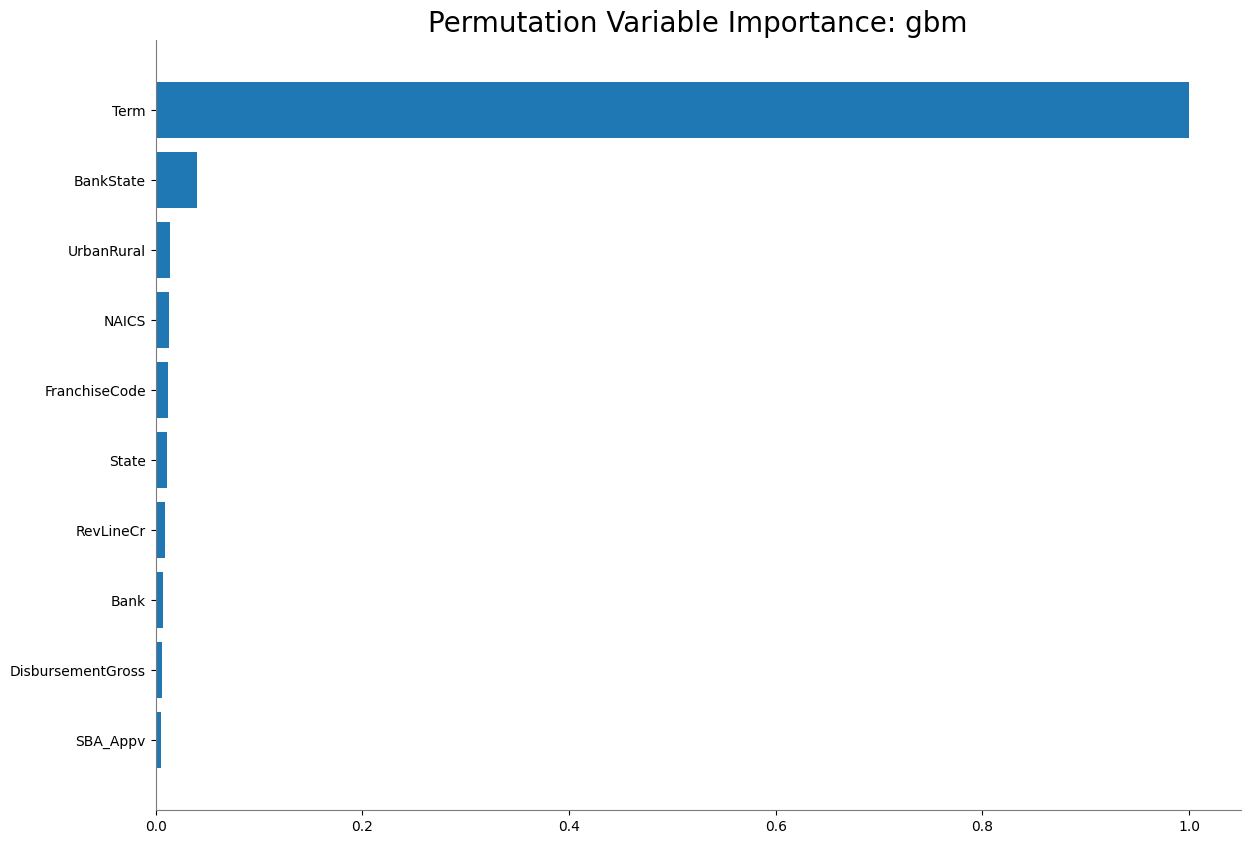

Variable,Relative Importance,Scaled Importance,Percentage
Term,0.4044000,1.0,0.8898451
BankState,0.0160970,0.0398046,0.0354199
UrbanRural,0.0055074,0.0136188,0.0121186
NAICS,0.0053041,0.0131159,0.0116711
FranchiseCode,0.0046800,0.0115728,0.0102980
State,0.0043931,0.0108632,0.0096666
RevLineCr,0.0037435,0.0092570,0.0082373
Bank,0.0029370,0.0072626,0.0064626
DisbursementGross,0.0025201,0.0062317,0.0055453
SBA_Appv,0.0018744,0.0046351,0.0041246


In [7]:
# plot permutation importance (bar plot)
gbm_model.permutation_importance_plot(test)

## Question 3

Calculate and plot PDP plot for the following columns: `"UrbanRural","SBA_Appv","DisbursementGross"`

You might find using following parameters useful: `nbins=52,figsize=(10, 10)` 

What is your conclusion for each of the variables?

### Solution

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


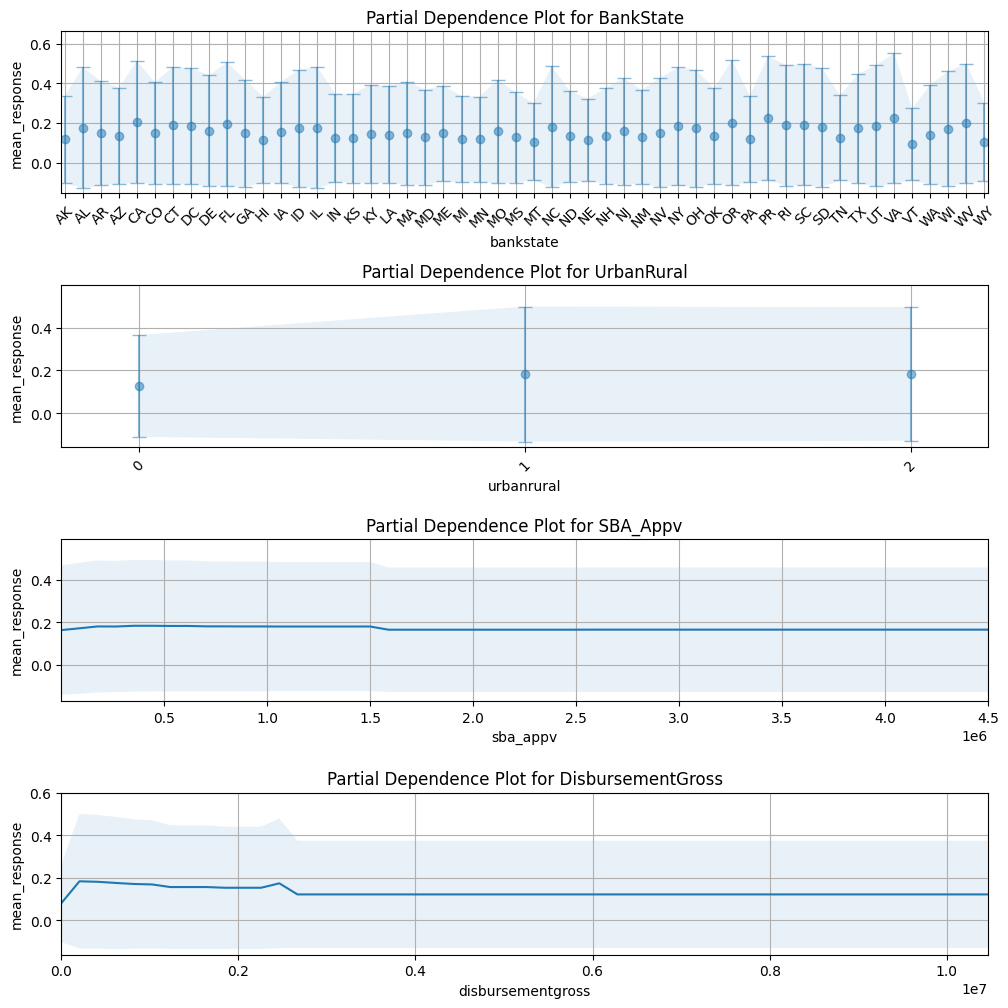

In [8]:
result = gbm_model.partial_plot(test, cols = ["BankState",
                                              "UrbanRural",
                                              "SBA_Appv","DisbursementGross"], 
                                nbins=52,figsize=(10, 10));
#result.figure()

## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values? 
- Why "Zip" feature is not rated at the top when many of the observations have significant high/low Shapley values? 

### Solution

- Most important feature is on top
- "Zip" feature has many records with Shapley value close to zero. The order of features in the summary plot is determined by summary of absolute Shapley values for each record (for the feature).

In [9]:
def examine_all_reason_codes(data, model):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    
    #Convert to Pandas DF
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols,
                             alpha=0.2
                            )

The order the features are appearing on the summary plot is based on feature importance.  
Feature importance that is based on Shapley values is calculated as sum (or average) of the absolute shapley values for the feature from the dataset (usually testing).

In [10]:
shap_contribs = gbm_model.predict_contributions(test)
df = shap_contribs.as_data_frame(use_pandas=True)
print("Sum Absolute Shapley values for:")
print("UrbanRural:",df["UrbanRural"].abs().sum().round(0))
print("BankState:",df["BankState"].abs().sum().round(0))

contributions progress: |████████████████████████████████████████████████████████| (done) 100%
Sum Absolute Shapley values for:
UrbanRural: 22348.0
BankState: 31371.0


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


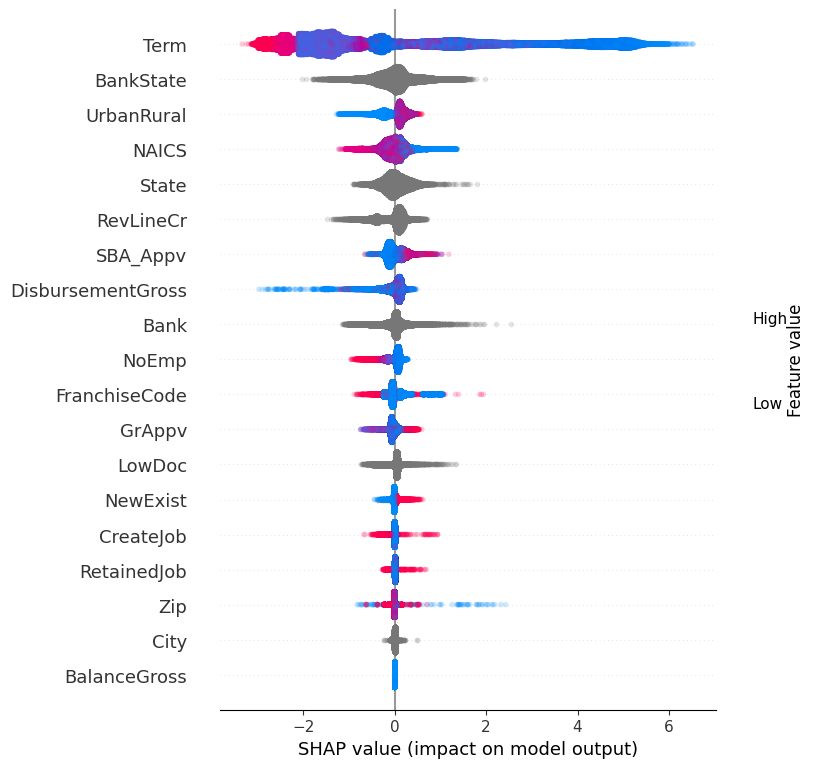

In [11]:
examine_all_reason_codes(test, gbm_model)

## Question 5

Plot individual Shapley values plots for records 0,1 and 4 in test dataset, for the total of 3 plots.
Explain each plot in terms of what are most influential features and how they impact model prediction.

### Solution

In [12]:
# The function is to calculate Shapley values (contributions) and plot them for single record
def examine_indiv_reason_codes(record, model, use_matplotlib=True):
    
    shap_contribs = model.predict_contributions(record)
    
    col_mapping = {}
    for i in record.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = record.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.force_plot(bias_term, 
                           shap_contribs[shap_cols].values, 
                           X[shap_cols].values, 
                           shap_cols,
                           link="logit",
                           matplotlib=use_matplotlib
                          )

In [13]:
shap.initjs()
#The non-matplotlib version produces better graphics but cannot be saved with notebook
examine_indiv_reason_codes(test[0, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


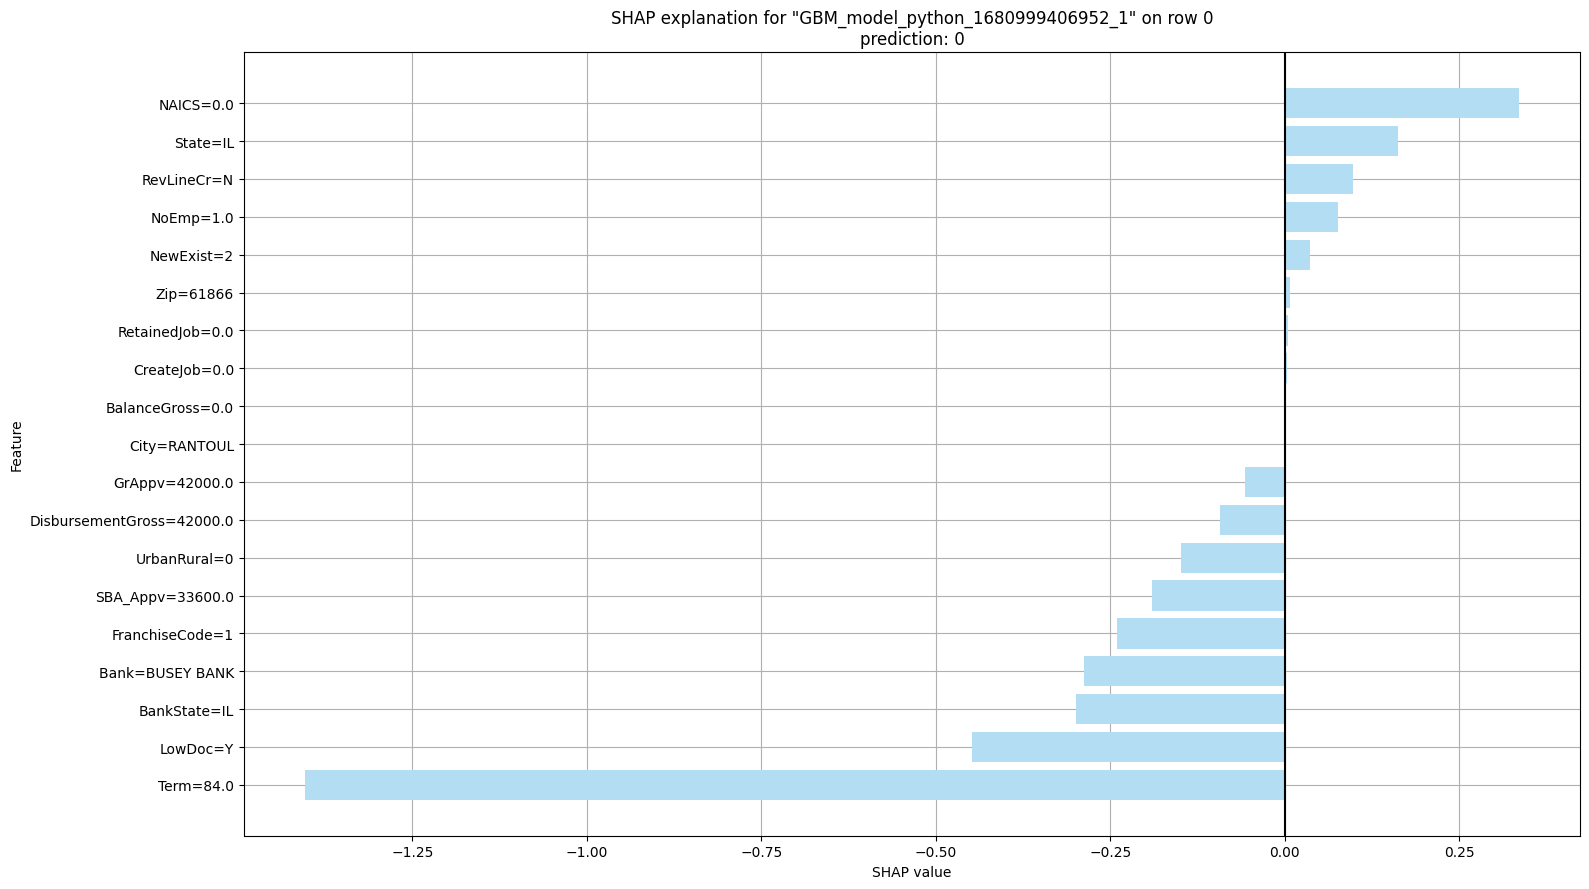

In [14]:
# Using H2O-3 plotting
gbm_model.shap_explain_row_plot(test, row_index=0)

In [15]:
examine_indiv_reason_codes(test[1, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [16]:
examine_indiv_reason_codes(test[4, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


## Question 6

Train decision tree surrogate model with 4 levels and plot the result.

If you run into problem with using Graphviz, you can use generate png file, look for below code:
```
java -cp h2o-genmodel.jar hex.genmodel.tools.PrintMojo --tree 0 -i "/path/to/model.zip" -o tree.png --format png
open tree.png
```
Documentation:

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html#viewing-a-mojo-model


### Solution

In [18]:
surrogate_dt_data = gbm_model.predict(train).cbind(train)
surrogate_dt_data.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
1,0.091548,0.908452,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2,2,1,0,1,N,N,25000,0,25000,21250,1
0,0.84265,0.15735,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2,0,0,0,0,N,N,52000,0,52000,46800,1
0,0.988261,0.0117395,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1,0,0,1,1,0,Y,150000,0,150000,127500,0
1,0.371384,0.628616,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1,0,20,10625,2,Y,N,186959,0,100000,50000,1
0,0.936854,0.0631461,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1,0,0,1,1,0,Y,50000,0,50000,40000,0
0,0.996638,0.00336198,BURNSVILLE,MN,55337,SPEDCO,MN,621330,240,2,1,4,2,1,1,0,N,266000,0,268000,268000,0
0,0.997155,0.00284489,"COEUR D'ALENE,",ID,83814,"PANHANDLE AREA COUNCIL, INC.",ID,0,240,24,2,24,0,1,0,N,N,343000,0,343000,343000,0
0,0.956794,0.043206,TRENTON,NJ,8638,WELLS FARGO BANK NATL ASSOC,SD,0,12,5,1,0,0,1,0,T,N,25000,0,25000,12500,0
1,0.498488,0.501512,MIAMI,FL,33134,BANK OF AMERICA NATL ASSOC,NC,236118,48,1,2,0,1,0,1,N,N,10177,0,10000,5000,1
0,0.949486,0.0505141,WATERTOWN,MA,2472,CITIZENS BANK NATL ASSOC,RI,512110,60,4,1,0,4,0,1,N,N,50000,0,50000,25000,0


In [19]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

dt = H2ORandomForestEstimator(model_id="surrogate.hex",
                              nfolds=3,
                              ntrees=1, max_depth=4,
                              sample_rate=1,
                              categorical_encoding="auto",
                              mtries=18, #number of features in the dataset
                              min_rows=20 # use min rows to prevent small leaf nodes and fitting noise
                             )
dt.train(y="p1", training_frame=surrogate_dt_data, x=predictors_gbm)

# retrieve the model performance
perf = dt.model_performance(surrogate_dt_data)
print("Surrogate Model R2:",perf.r2())

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Surrogate Model R2: 0.6710395932273157


In [20]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(model, tree_number):
    # Download MOJO
    mojo_path = model.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", str(tree_number), "-i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o decision_tree.png"], shell=False)
    result = subprocess.call(["ls","decision_tree.png"], shell = False)
    
    return Image(" decision_tree.png")

In [24]:
import os
from IPython.display import Image
def generateTreeImage_v1(model, tree_number):
    # Download MOJO
    mojo_path = model.download_mojo(get_genmodel_jar=True)
    gv_call = " ".join(["java", "-cp", "h2o-genmodel.jar", "hex.genmodel.tools.PrintMojo", "--tree", str(tree_number), "-i", "surrogate_hex.zip" , "-o decision_tree.png --format png"])
    os.system(gv_call)
    
    return Image("decision_tree.png")

/Users/usmashnov/Documents/UTD/Spring-2023/Lab-7/decision_tree.gv


ls: decision_tree.png: No such file or directory


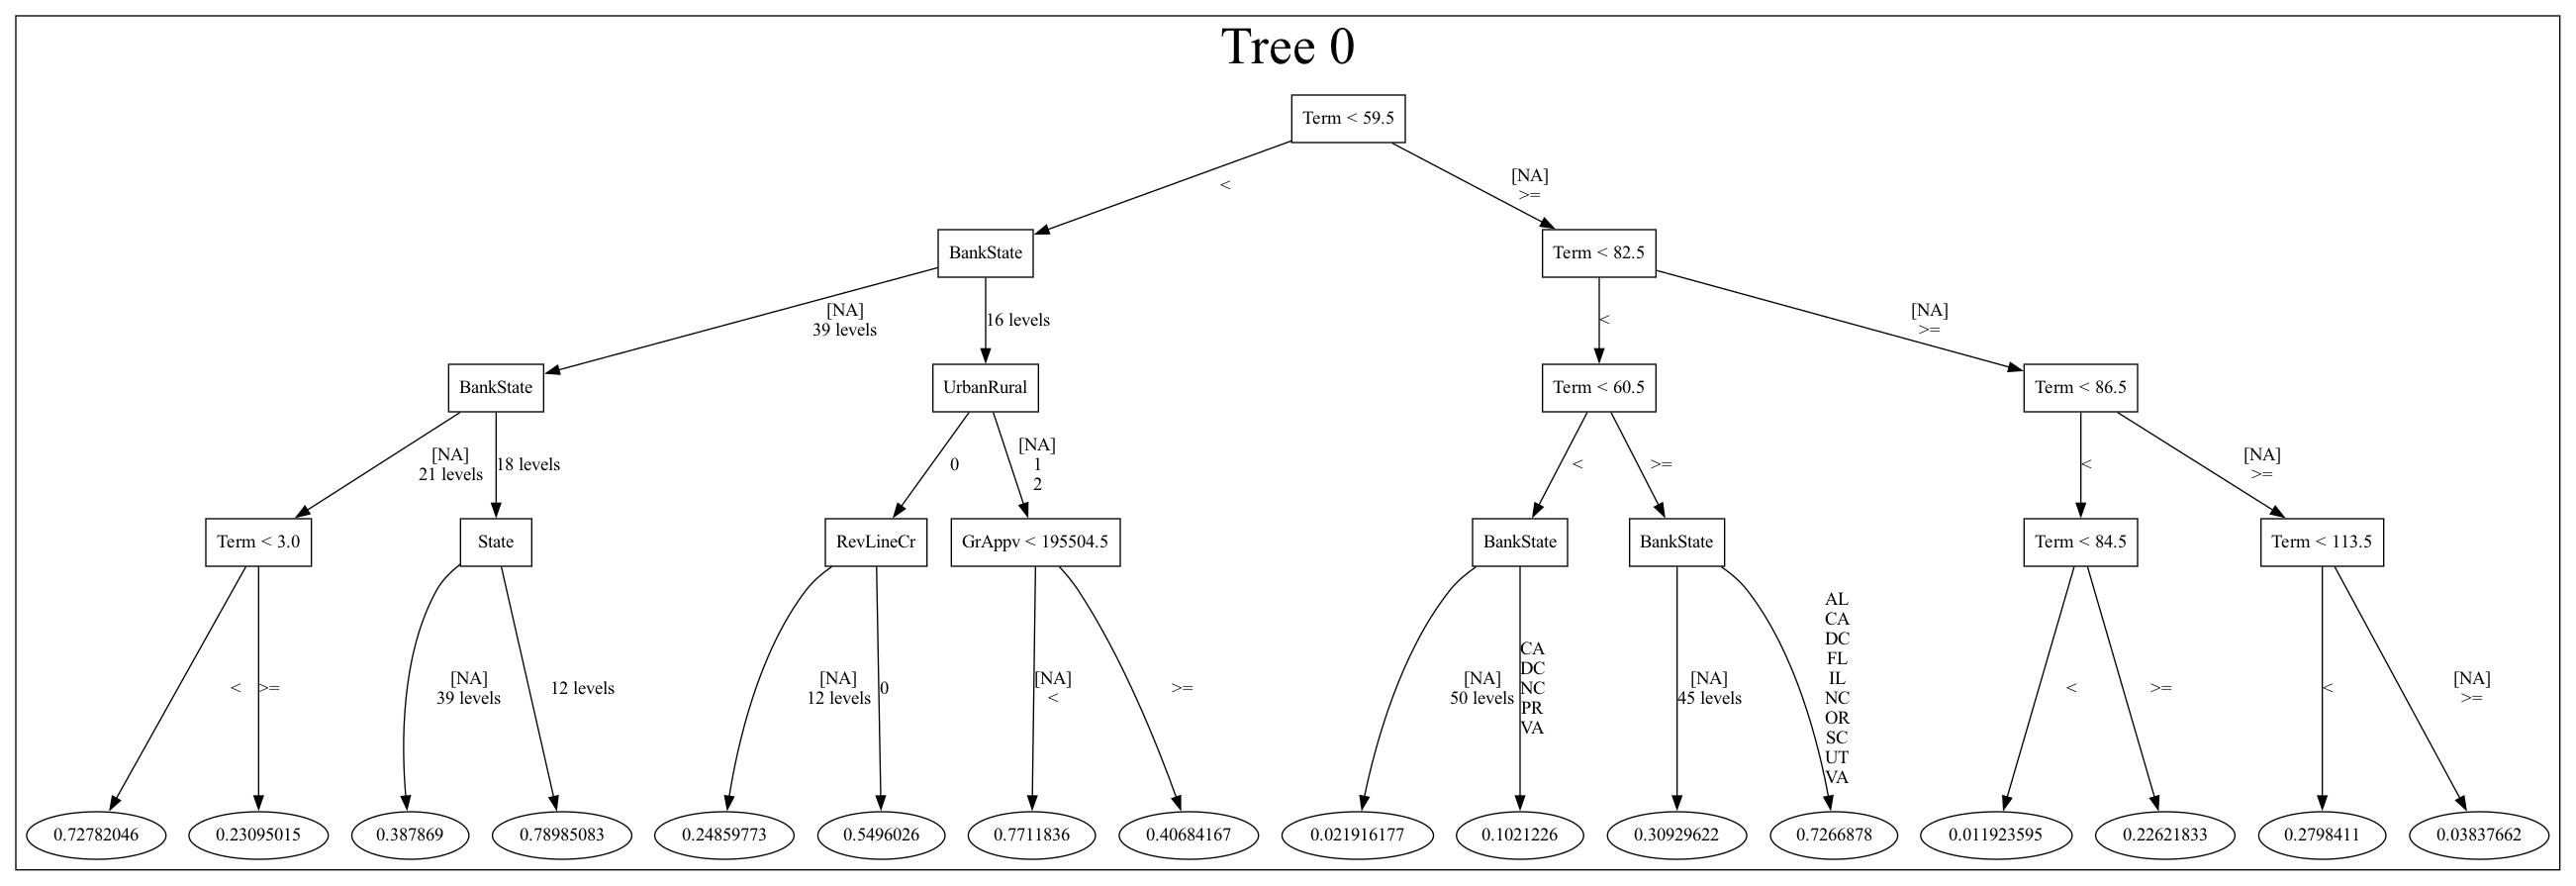

In [21]:
generateTreeImage(dt, 0)

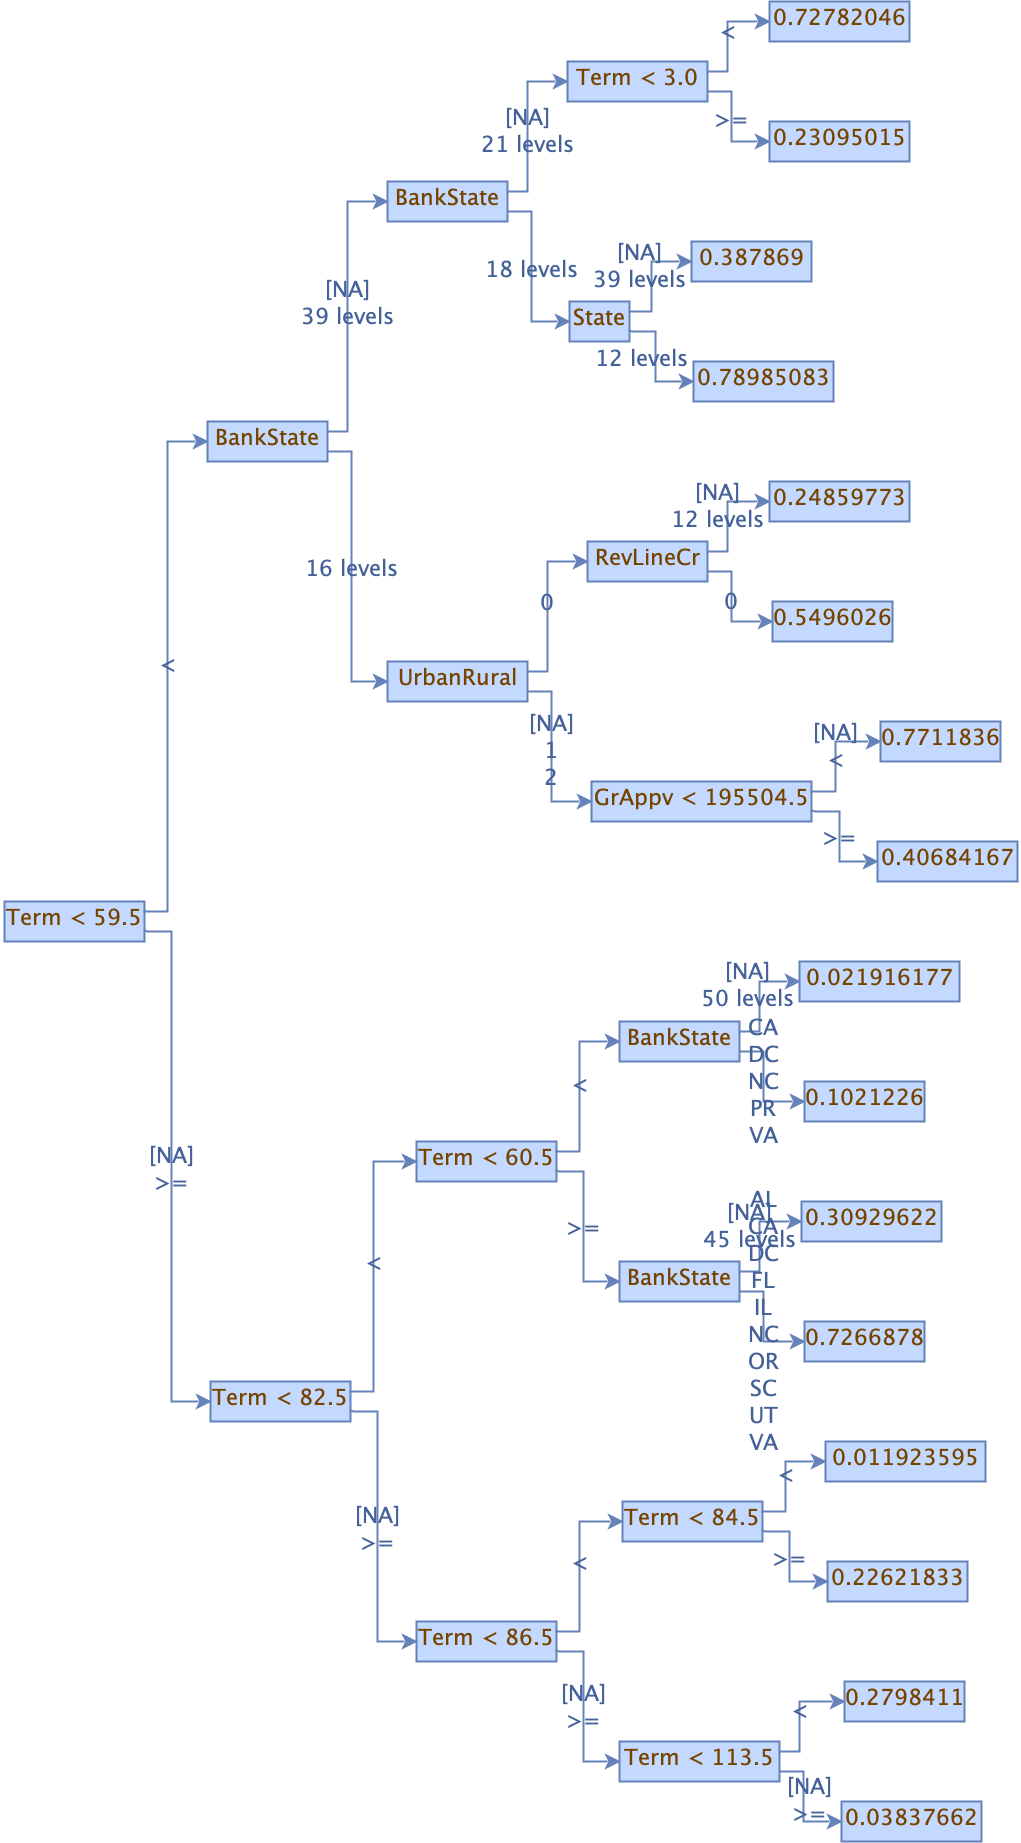

In [25]:
generateTreeImage_v1(dt, 0)